# **Resumo**

Este notbook tem como objetivo realizar a análise exploratório do dataset disponilizado pelo Hospital Sírio-Libanês no Kaggle. 

A análise irá permitir entender o conjunto de dados a ser trabalhado e pré-processar estes dados para uma forma que seja ideal para trabalharmos durante a construção do modelo preditivo e análise estatística.

Uma parte do processamento dos dados já foi feita pelo próprio Hospital Sírio-Libanês, anonimizando os dados coletados, normalizando os dados dentro de um intervalo de -1 a 1 e limpando os dados com problemas.


## **Estruturação dos dados**

**Chave identificadora (Unique ID)**

O identificador único do paciente é a coluna "PATIENT_VISIT_IDENTIFIER".

**Variável a ser prevista pelo modelo**

A variável a ser prevista é a coluna "ICU", que identifica se em algum momento o paciente foi ou não para a UTI.

**Janela de tempo**

A coluna "WINDOW" identifica as janelas de tempo do paciente desde a admissão, sendo composta pelos seguintes intervalos:

| Janela | Descrição |
|--------|-----------|
| 0-2 | Entre 0 até 2 horas a partir da admissão do paciente |
| 2-4 | Entre 2 até 4 horas a partir da admissão do paciente |
| 4-6 | Entre 4 até 6 horas a partir da admissão do paciente |
| 6-12 | Entre 6 até 12 horas a partir da admissão do paciente |
| Above-12 | Mais de 12 horas horas a partir da admissão do paciente |

**Demais variáveis**

Temos as seguintes informações sobre o paciente:

| Janela |
|--------|
|Informações demográficas do paciente|
|Grupos de doenças previamente identificadas nos pacientes|
|Resultados de exames de sangue|
|Sinais vitais|

Temos um total de 54 colunas correspondente a 54 variáveis, sendo estas médias, mínimos, máximos, medianas e diferenças.

**Dados faltantes**

Devido às janelas de intervalo entre a coleta de dados de um paciente, não temos informações de alguns dos exames feitos nestas janelas. Uma solução proposta pelo Hospital é a de utilizar os ressultados de exames de outras janelas do mesmo paciente, visto que o paciente está clinicamente estável em um intervalo de tempo tão curto.

**Problema a ser solucionado**

A identificação precoce dos pacientes que desenvolverão um curso adverso da doença (e precisam de cuidados intensivos) é a chave para um tratamento adequado (salvar vidas) e para gerenciar leitos e recursos. Um bom modelo usando apenas a primeira janela (0-2) provavelmente será mais clinicamente relevante, por esta razão os dados serão reorganizados a fim de agrupar os dados médicos por paciente e apenas as informações da primeira janela serão utilizadas para identificar se um paciente precisou de internação em qualquer uma das janelas.

|Escopo do notebook|
|--------|
|Importação dos pacotes|
|Importação das funções locais|
|Leitura dos dados brutos|
|Pré-processamento|
|Análise da variável alvo|
|Análise das informações demográficas|
|Análise das demais variáveis categóricas|
|Análise das variáveis numéricas|
|Salvamento dos dados pré-processados|



# **Pré-Processamento**

## **Importação das bibliotecas gerais**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## **Configuração dos estilos dos elementos visuais, remoção e seed**

In [2]:
sns.set_style('darkgrid')

seed = 324551

## **Importação das funções de pré-processamento**

In [3]:
import os
os.chdir("../Funcoes")
from features import teste_chi2, teste_high_corr, binary_features
from func_plot import labs, annot_bar
from pre_processamento import bfill_ffill_table, select_window
os.chdir("../Notebooks")

## **Importação do dataset**

In [4]:
df = pd.read_excel('../Dados/Dados_brutos/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

# **Análise Exploratória**

## Verificação das colunas, dados e tamanho do dataset

In [5]:
df.head(5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [6]:
df.shape

(1925, 231)

## Verificação da quantidade de valores nulos no dataset

In [7]:
df.isna().sum().sum()

223863

Como foi dito inicialmente, temos uma grande quantidade de células com dados nulos devido a falta de testes em certos intervalos. Para corrigirmos este problema, iremos preencher estes dados com base em janelas próximos do mesmo paciente, conforme recomendado pelo próprio hospital.

In [8]:
df = df.groupby(['PATIENT_VISIT_IDENTIFIER', 'ICU']).apply(bfill_ffill_table)

In [9]:
df.isna().sum().sum()

8781

Como dito, o número de células em branco reduziu consideralmente, retornando apenas algumas com valores nulos, que deverão ser desconsideradas do modelo, por isto iremos removê-las do dataset.

In [10]:
df = df.dropna()

In [11]:
df.isna().sum().sum()

0

Outro caso que devemos desconsiderar, é quando o paciente já foi admitido diretamente para a UTI.

In [12]:
rows_to_remove = df[(df['WINDOW'] == '0-2') & (df['ICU'] == 1)].index
df.drop(index=rows_to_remove, inplace=True)
df = df.groupby('PATIENT_VISIT_IDENTIFIER').apply(select_window)
df.drop(['WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(294, 229)

O próximo passo será converter as colunas com dados binários para o formato correto.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 229 entries, AGE_ABOVE65 to ICU
dtypes: float64(225), int64(3), object(1)
memory usage: 526.1+ KB


In [14]:
binary = binary_features(df)
binary

['AGE_ABOVE65',
 'GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ICU']

In [15]:
df[binary] = df[binary].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 229 entries, AGE_ABOVE65 to ICU
dtypes: float64(216), int64(12), object(1)
memory usage: 526.1+ KB


# Análise da variável alvo (ICU)

In [16]:
df['ICU']

0      1
1      1
2      0
3      0
4      0
      ..
289    1
290    0
291    1
292    0
293    0
Name: ICU, Length: 294, dtype: int64

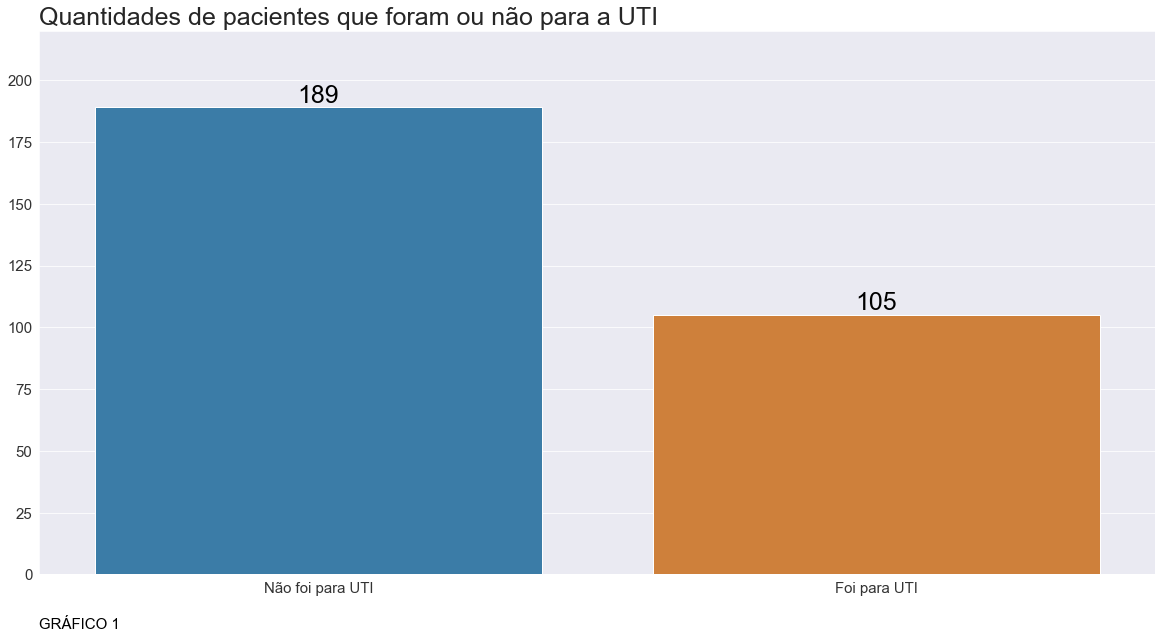

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(df['ICU'], ax=ax, palette=['#2980b9', '#e67e22'])

labs(title='Quantidades de pacientes que foram ou não para a UTI',
     xlabel='', ylabel='',ax=ax)

annot_bar(prop=False, ax=ax, fontsize=25)
plt.ylim([0,220])
plt.xticks(range(2),['Não foi para UTI', 'Foi para UTI'])
plt.text(0,-0.1, 'GRÁFICO 1', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

Análise das variáveis demográficas

Eliminando a coluna de gênero por questões éticas

In [18]:
df.drop('GENDER', axis=1, inplace=True)

Tratamento da coluna de idade percentil para podermos utilizar no modelo ML.

In [19]:
percentil_prop = df.groupby('AGE_PERCENTIL')['ICU'].value_counts(normalize=True).reset_index(name='Prop')
percentil_prop

,AGE_PERCENTIL,ICU,Prop
0,10th,0,0.833333
1,10th,1,0.166667
2,20th,0,0.815789
3,20th,1,0.184211
4,30th,0,0.676471
5,30th,1,0.323529
6,40th,0,0.757576
7,40th,1,0.242424
8,50th,0,0.580645
9,50th,1,0.419355


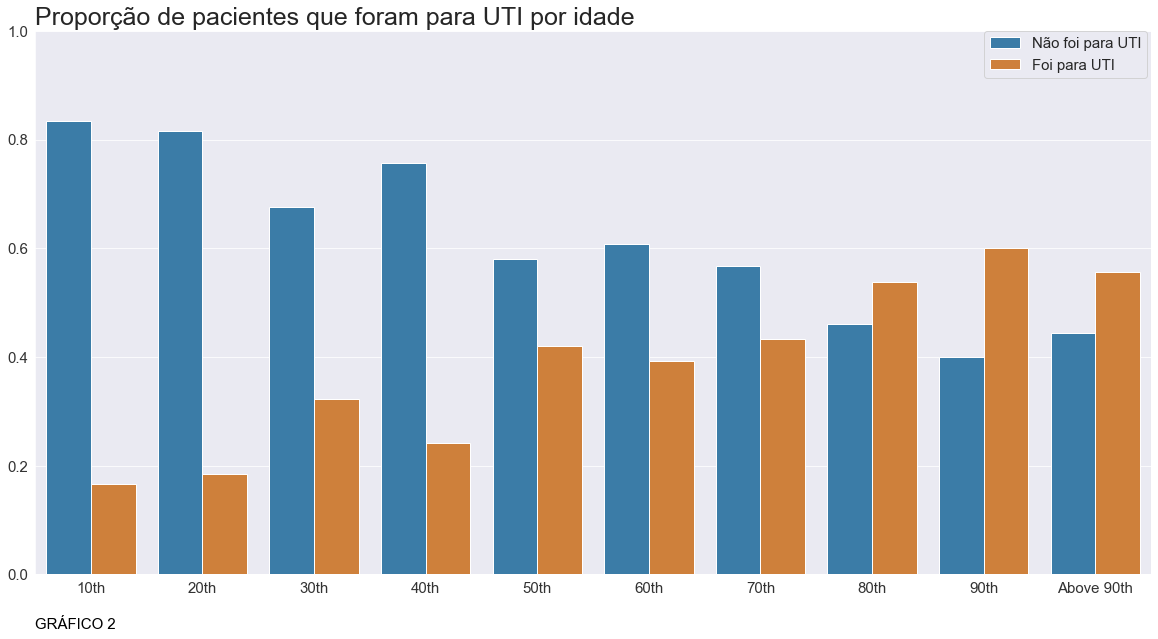

In [20]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.barplot(data=percentil_prop, y='Prop', x='AGE_PERCENTIL', hue='ICU', ax=ax, palette=['#2980b9', '#e67e22'])

labs(title='Proporção de pacientes que foram para UTI por idade', 
     xlabel='', ylabel='',ax=ax)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0., fontsize=15)
plt.ylim([0,1])
plt.text(0,-0.1, 'GRÁFICO 2', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

Criação de variáveis categóricas para percentis de idade que sofrem maiores alterações.

In [21]:
df['AGE_UNDER_30th']=[1 if row['AGE_PERCENTIL'] in ['10th', '20th'] 
                      else 0 for _,row in df.iterrows()] 

df['AGE_UNDER_50th']=[1 if row['AGE_PERCENTIL'] in ['10th', '20th','30th', '40th'] 
                      else 0 for _,row in df.iterrows()] 

df['AGE_ABOVE_50th']=[1 if row['AGE_PERCENTIL'] in ['50th','60th', '70th','80th', '90th', 'Above 90th'] 
                      else 0 for _,row in df.iterrows()]

df['AGE_ABOVE_80th']=[1 if row['AGE_PERCENTIL'] in ['80th', '90th', 'Above 90th'] 
                      else 0 for _,row in df.iterrows()] 

df.drop('AGE_PERCENTIL', axis=1, inplace=True)
df.head()

,AGE_ABOVE65,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,...,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_UNDER_30th,AGE_UNDER_50th,AGE_ABOVE_50th,AGE_ABOVE_80th
0,1,0,0,0,0,1,1,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0,1,1,0,0


## Teste de Chi Quadrado

In [22]:
ages = ['AGE_UNDER_30th','AGE_UNDER_50th','AGE_ABOVE_50th','AGE_ABOVE_80th','AGE_ABOVE65', 'ICU']
ages_melt = pd.melt(df[ages], id_vars='ICU')
ages_prop = ages_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [23]:
valores_p = teste_chi2(df[ages].drop('ICU', axis=1), df['ICU'])
for col, p_value in valores_p.items():
    print(f'A coluna {col} obteve um p valor igual a {np.round(p_value,4)}')

A coluna AGE_UNDER_30th obteve um p valor igual a 0.0011
A coluna AGE_UNDER_50th obteve um p valor igual a 0.0013
A coluna AGE_ABOVE_50th obteve um p valor igual a 0.002
A coluna AGE_ABOVE_80th obteve um p valor igual a 0.0006
A coluna AGE_ABOVE65 obteve um p valor igual a 0.0014


## Análise de correção entre as variáveis

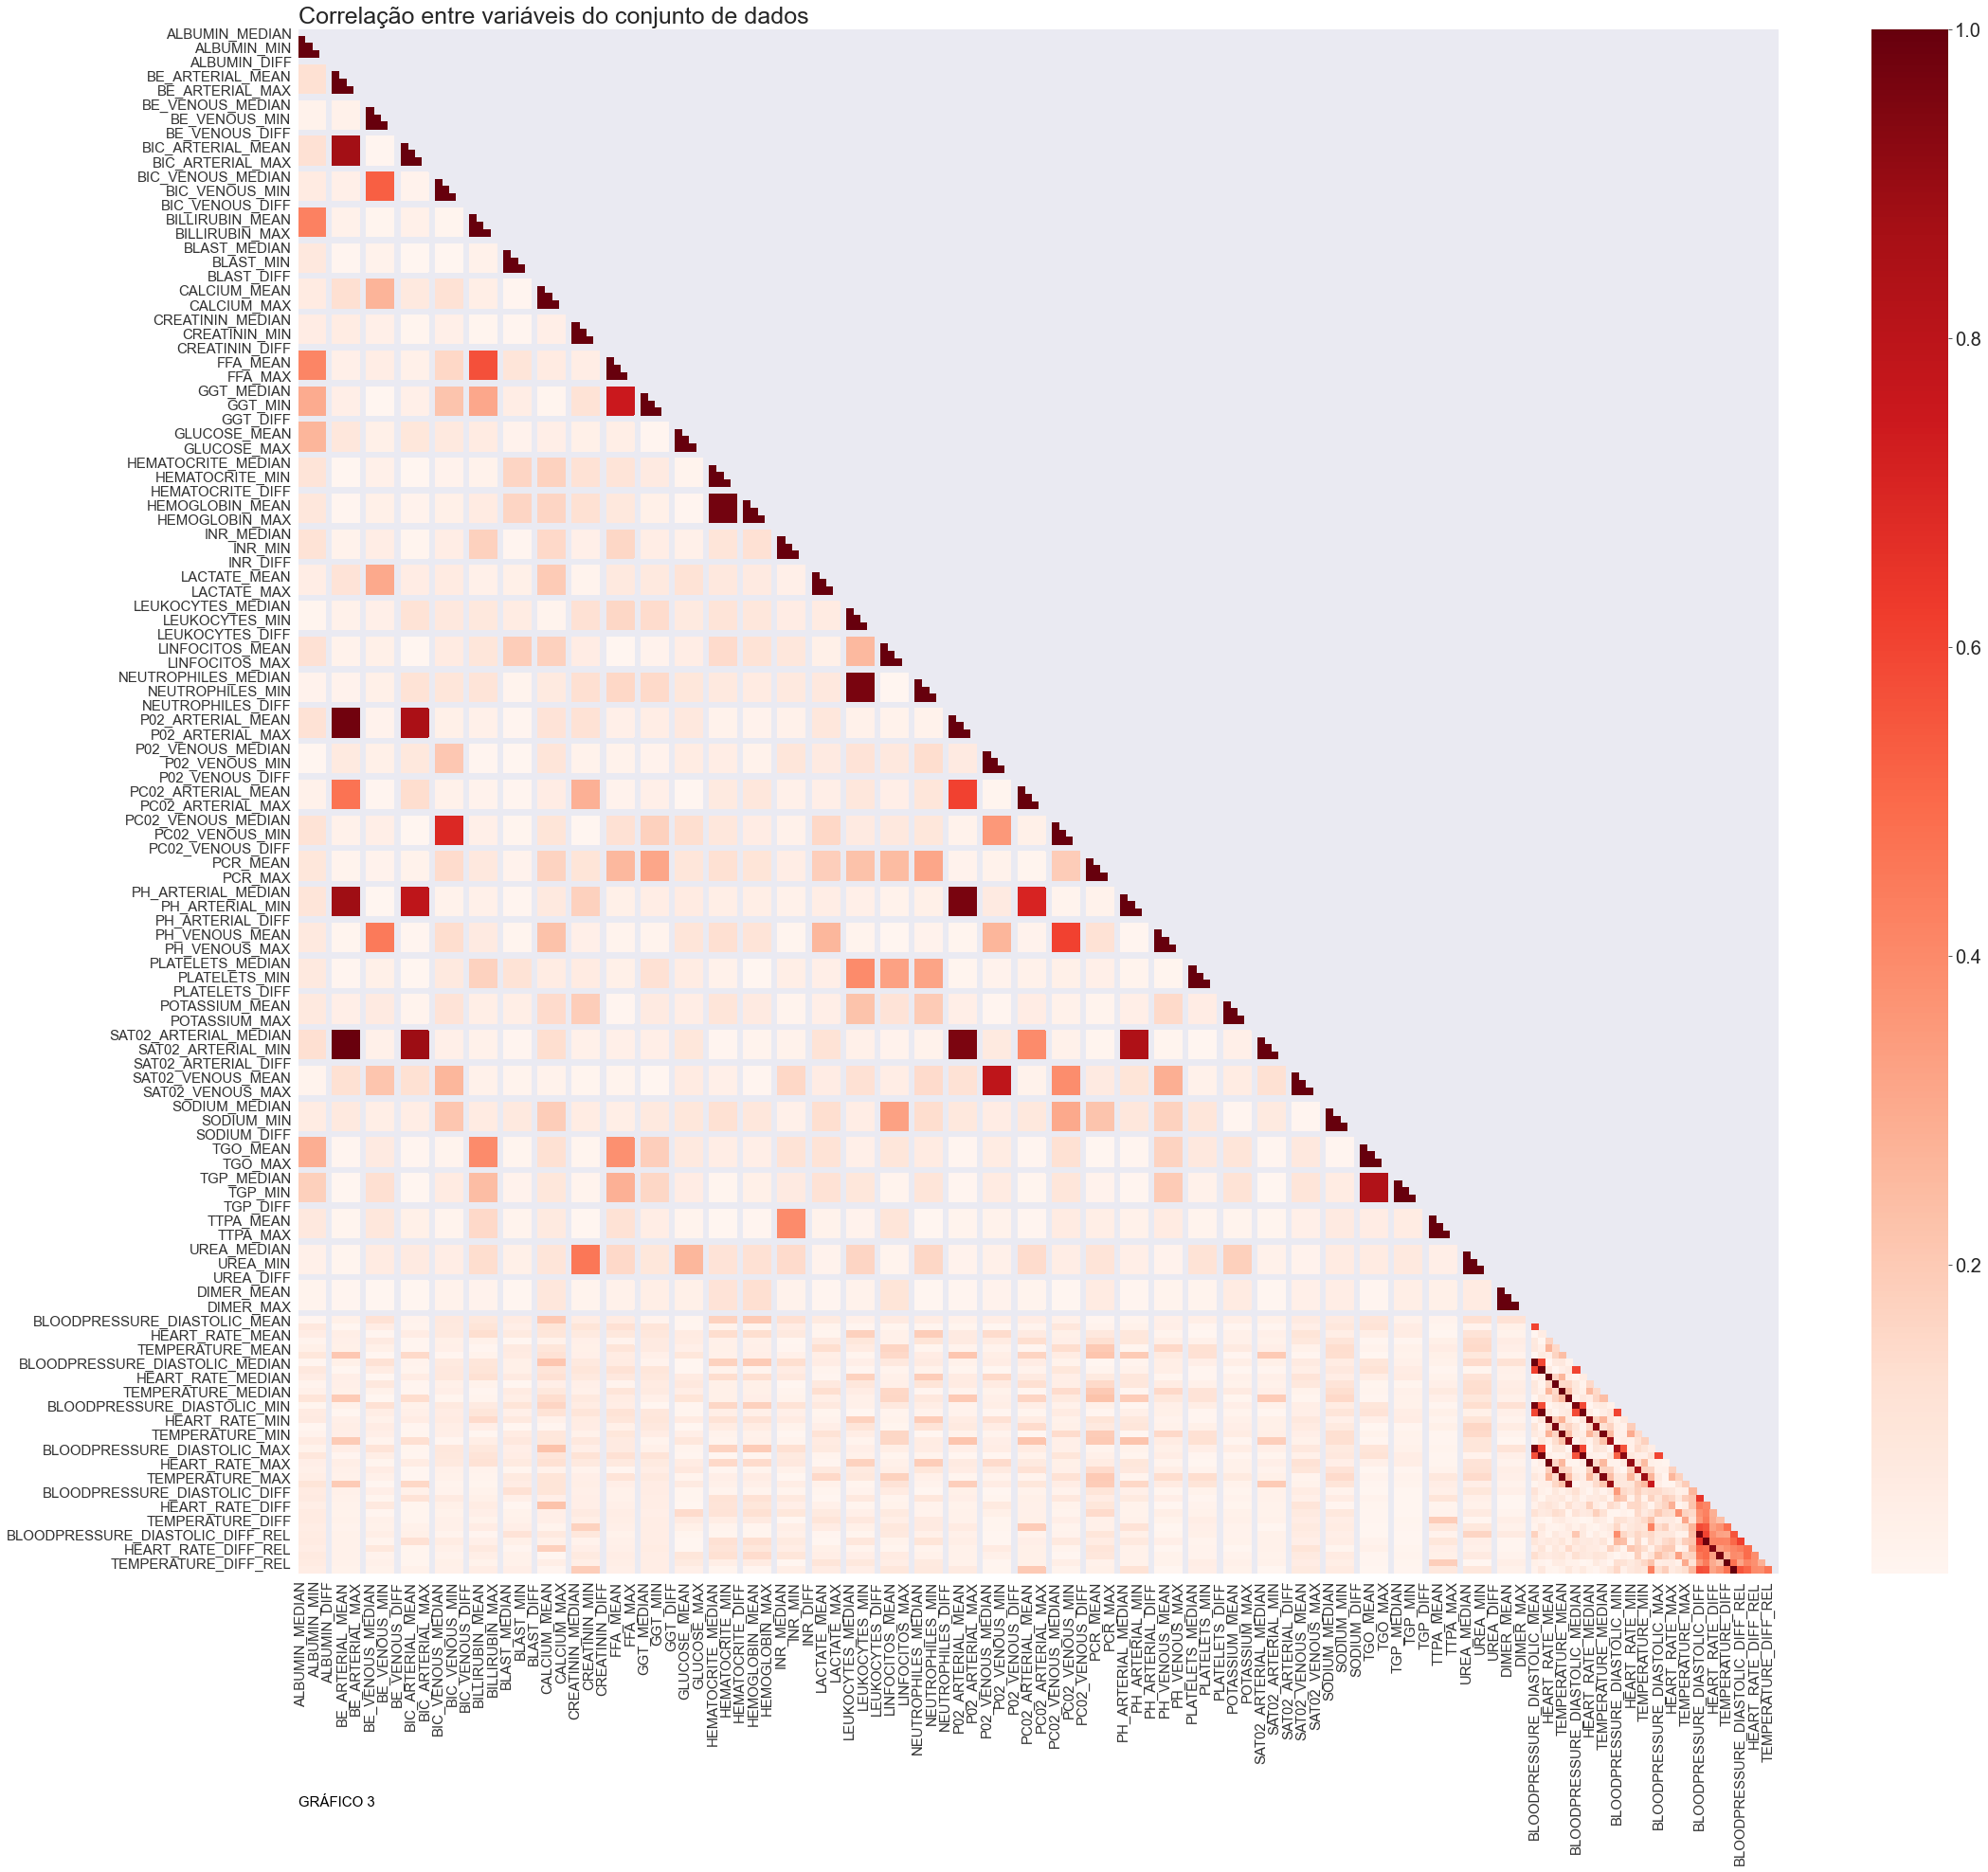

In [24]:
fig,ax = plt.subplots(figsize=(35, 30))
cor = df.select_dtypes('float64').corr().abs()
mask = np.triu(np.ones_like(cor, dtype=bool))

sns.heatmap(cor,
            cmap='Reds',
            mask=mask,
            ax=ax)

labs(title='Correlação entre variáveis do conjunto de dados', ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.text(0,-0.15, 'GRÁFICO 3', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

Eliminando as colunas de alta correlação para que apenas uma delas continue no
dataset, visto a não haver multipla influencia de variáveis correlacionadas.

In [25]:
cols_drop_high_corr = teste_high_corr(df.select_dtypes('float64'), 0.95)
print(cols_drop_high_corr)
print(len(cols_drop_high_corr))

['ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CREATININ_MEAN', 'CREATININ_MIN', 'CREATININ_MAX', 'FFA_MEAN', 'FFA_MIN', 'FFA_MAX', 'GGT_MEAN', 'GGT_MIN', 'GGT_MAX', 'GLUCOSE_MEAN', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX', 'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'HEMOGLOBIN_MAX', 'INR_MEAN', 'INR_MIN', 'INR_MAX', 'LACTATE_MEAN', 'LACTATE_MIN', 'LACTATE_MAX', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN', 'LEUKOCYTES_MAX', 'LINFOCITOS_MEAN', 'LINFOCITOS_MIN', 'LINFOCITOS_MAX', 'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MIN', 'NEUTROPHILES_MAX', 'P02_ARTERIA

In [26]:
df.drop(cols_drop_high_corr, axis=1, inplace=True)

## Análise da variância

In [27]:
np.random.seed(seed)
cont = df.select_dtypes('float64')
sample = cont[np.random.choice(cont.columns, size=10, replace=False)]
sample_cont = pd.concat([sample, df['ICU']],axis=1) 
cont_melt = pd.melt(sample_cont, id_vars='ICU')
cont_melt.head()

,ICU,variable,value
0,1,HEMATOCRITE_MEDIAN,0.090147
1,1,HEMATOCRITE_MEDIAN,0.144654
2,0,HEMATOCRITE_MEDIAN,-0.203354
3,0,HEMATOCRITE_MEDIAN,0.358491
4,0,HEMATOCRITE_MEDIAN,0.291405


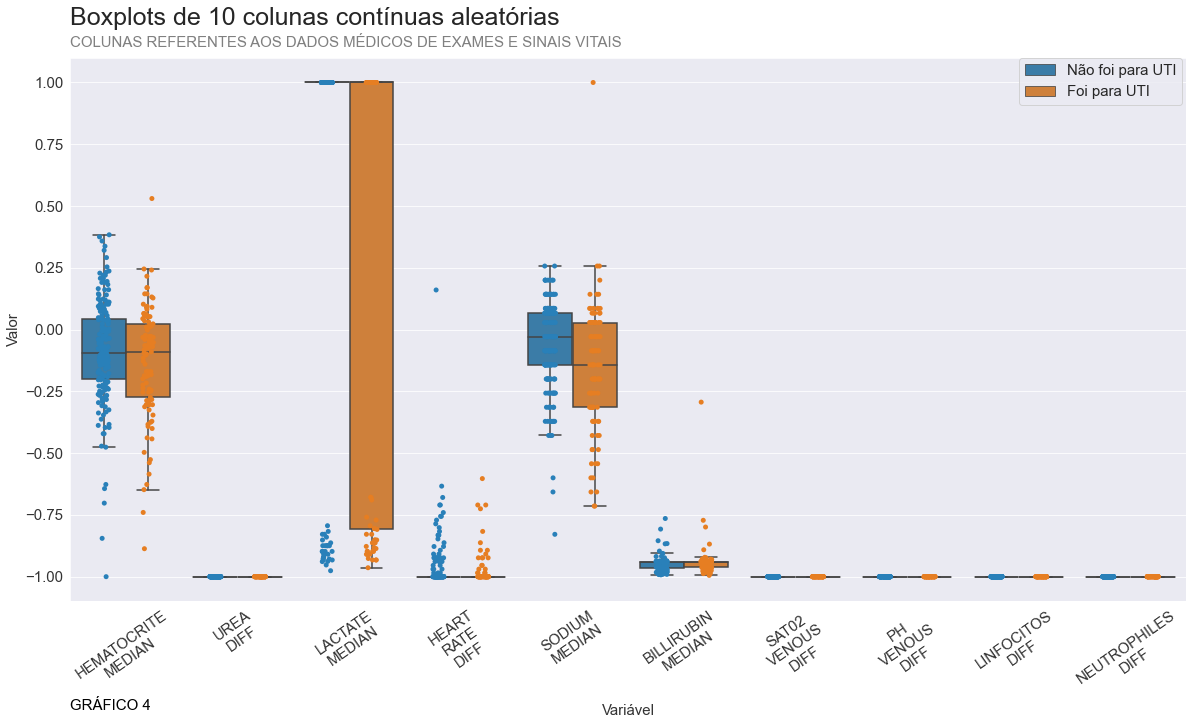

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

sns.boxplot(x='variable', y='value', hue='ICU',
            data=cont_melt, palette=['#2980b9', '#e67e22'], 
            ax=ax, showfliers=False)

sns.stripplot(x='variable', y='value', hue='ICU',
              data=cont_melt, palette=['#2980b9', '#e67e22'],
              ax=ax, dodge=True)

labs(title='Boxplots de 10 colunas contínuas aleatórias', 
     xlabel='Variável', 
     ylabel='Valor', 
     subtitle='COLUNAS REFERENTES AOS DADOS MÉDICOS DE EXAMES E SINAIS VITAIS', ax=ax)

plt.xticks(range(10),labels=cont_melt['variable'].str.split('_').str.join('\n').unique(), rotation=35)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0., fontsize=15)
plt.text(0,-0.20, 'GRÁFICO 4', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

In [29]:
var = df.select_dtypes('float64').var()
var.sort_values().head()

PC02_ARTERIAL_DIFF    0.0
PH_ARTERIAL_DIFF      0.0
HEMATOCRITE_DIFF      0.0
HEMOGLOBIN_DIFF       0.0
INR_DIFF              0.0
dtype: float64

In [30]:
cols_0_var = [col for col in var.index if var[col] == 0]
print(cols_0_var)
print(len(cols_0_var))

['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF', 'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF', 'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF', 'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF', 'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF', 'P02_VENOUS_DIFF', 'PC02_ARTERIAL_DIFF', 'PC02_VENOUS_DIFF', 'PCR_DIFF', 'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF', 'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF', 'SAT02_VENOUS_DIFF', 'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF', 'UREA_DIFF', 'DIMER_DIFF']
36


Elimando as colunas com variância igual a zero

In [31]:
df.drop(cols_0_var,axis=1, inplace=True)
df.head()

,AGE_ABOVE65,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_UNDER_30th,AGE_UNDER_50th,AGE_ABOVE_50th,AGE_ABOVE_80th
0,1,0,0,0,0,1,1,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,1,0,0


In [32]:
df.shape

(294, 61)

No final, selecionamos 61 das 231 colunas para usarmos na modelagem.

# Salvando o dataset pré-processado para utilização na criação dos modelos de ML

In [33]:
df.to_csv('../Dados/Dados_limpos/dados_preprocessados.csv', index=False)